In [19]:
import pandas as pd
import numpy as np
from scipy.special import expit
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

In [20]:
import sys
sys.path.append('../scripts/')

from data_cleaner import DataCleaner
from util import Util

In [23]:
util = Util()
cleaner = DataCleaner()

In [24]:
repo = 'https://github.com/kebishaa/Delivery_drivers_location_optimisation-_with_Causal_Inference-'
trip_data_tag = '1usMS7obAXRC6MBpn-wEbQPLlRXYb2mIT'
trip = util.load_from_dvc("data/nb.csv",repo,trip_data_tag,low_memory=False)

In [25]:
repo = 'https://github.com/kebishaa/Delivery_drivers_location_optimisation-_with_Causal_Inference-'
order_data_tag = '1usMS7obAXRC6MBpn-wEbQPLlRXYb2mIT'
order = util.load_from_dvc("data/driver_locations_during_request.csv",repo,order_data_tag,low_memory=False)

In [26]:
trip_miss_info = trip.isna().sum()
trip_miss_info

Trip ID                0
Trip Origin            0
Trip Destination       0
Trip Start Time     1651
Trip End Time          1
dtype: int64

In [27]:
order_miss_info = order.isna().sum()
order_miss_info

id                     0
order_id               0
driver_id              0
driver_action          0
lat                    0
lng                    0
created_at       1557740
updated_at       1557740
dtype: int64

Table Merge

In [28]:
df = order.merge(trip, how='inner', left_on='order_id', right_on='Trip ID')
df.head()

,id,order_id,driver_id,driver_action,lat,lng,created_at,updated_at,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time
0,1,392001,243828,accepted,6.602207,3.270465,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36
1,2,392001,243588,rejected,6.592097,3.287445,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36
2,3,392001,243830,rejected,6.596133,3.281784,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36
3,4,392001,243539,rejected,6.596142,3.280526,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36
4,5,392001,171653,rejected,6.609232,3.288800,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36


In [30]:
df.isna().sum()

id                        0
order_id                  0
driver_id                 0
driver_action             0
lat                       0
lng                       0
created_at          1557740
updated_at          1557740
Trip ID                   0
Trip Origin               0
Trip Destination          0
Trip Start Time        2022
Trip End Time             0
dtype: int64

In [31]:
# Cleaning the created_at and updated_at columns since they don't have any valuable information
cleaned_df = cleaner.drop_columns(df, ['updated_at','created_at'])
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1557740 entries, 0 to 1557739
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1557740 non-null  int64  
 1   order_id          1557740 non-null  int64  
 2   driver_id         1557740 non-null  int64  
 3   driver_action     1557740 non-null  object 
 4   lat               1557740 non-null  float64
 5   lng               1557740 non-null  float64
 6   Trip ID           1557740 non-null  int64  
 7   Trip Origin       1557740 non-null  object 
 8   Trip Destination  1557740 non-null  object 
 9   Trip Start Time   1555718 non-null  object 
 10  Trip End Time     1557740 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 142.6+ MB


Calculating the distance between drivers and Trip Origin

In [40]:
from geopy.distance import geodesic
sample = df.copy()
sample[["Trip_Origin_x", "Trip_Origin_y"]] = sample["Trip Origin"].str.strip(r"[()]").str.split(",", expand=True).astype(float)

In [41]:
sample.head()

,id,order_id,driver_id,driver_action,lat,lng,created_at,updated_at,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,Trip_Origin_x,Trip_Origin_y
0,1,392001,243828,accepted,6.602207,3.270465,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,6.601042,3.276634
1,2,392001,243588,rejected,6.592097,3.287445,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,6.601042,3.276634
2,3,392001,243830,rejected,6.596133,3.281784,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,6.601042,3.276634
3,4,392001,243539,rejected,6.596142,3.280526,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,6.601042,3.276634
4,5,392001,171653,rejected,6.609232,3.288800,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,6.601042,3.276634


In [42]:
sample['driver_proximity'] = sample.apply(
    (lambda row: geodesic(
        (row['lat'], row['lng']),
        (row['Trip_Origin_x'], row['Trip_Origin_y'])
    ).miles),
    axis=1
)

In [43]:
sample.head()

,id,order_id,driver_id,driver_action,lat,lng,created_at,updated_at,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,Trip_Origin_x,Trip_Origin_y,driver_proximity
0,1,392001,243828,accepted,6.602207,3.270465,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,6.601042,3.276634,0.431395
1,2,392001,243588,rejected,6.592097,3.287445,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,6.601042,3.276634,0.964178
2,3,392001,243830,rejected,6.596133,3.281784,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,6.601042,3.276634,0.488880
3,4,392001,243539,rejected,6.596142,3.280526,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,6.601042,3.276634,0.430022
4,5,392001,171653,rejected,6.609232,3.288800,NaN,NaN,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,6.601042,3.276634,1.007770


In [ ]:
import geopandas as gpd



In [33]:
import pandas as pd
import datashader as ds
import colorcet as cc

sample = pd.read_csv('../data/nb.csv', usecols=['Trip Origin', 'Trip Destination'])
sample.shape()

TypeError: 'tuple' object is not callable

In [13]:
import numpy as np

sample[["x", "y"]] = sample["Trip Destination"].str.strip(r"[()]").str.split(",", expand=True).astype(float)

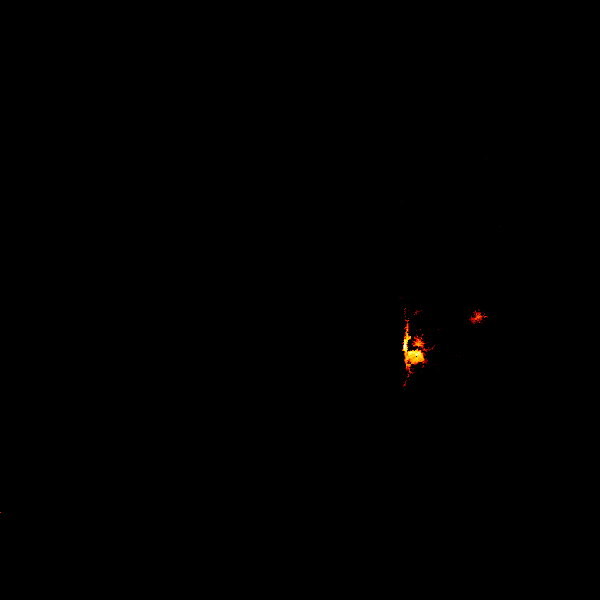

In [15]:
agg = ds.Canvas().points(sample, 'x', 'y')
ds.tf.set_background(ds.tf.shade(agg, cmap=cc.fire), "black")